In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import theano.tensor as tt
import arviz as az
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_absolute_error, classification_report

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Model

- Starting point is to model the number of goals in a game by team 1 and team 2 using 2 Poisson distributions:</br>
$y_{g1}$ | $\theta_{g1}$ ~ Poisson($\theta_{g1}$)</br>
$y_{g2}$ | $\theta_{g2}$ ~ Poisson($\theta_{g2}$)</br>
where $\theta_{gi}$ represents the scoring intensity in the $g^{th}$ game</br>
</br>
- $\theta$ is modeled assuming log-linear random effect model:</br>
$log\theta_{g1}$ = $att_{1(g)}$ + $def_{2(g)}$</br>
$log\theta_{g2}$ = $att_{2(g)}$ + $def_{1(g)}$</br>
This formulation is slightly different from the commonly used one with home effect as worldcup has only very limited home effect in data</br>
</br>
- Each of the team specific effects are modeled as exchangeable from a common distribution:</br>
$att_{t}$ ~ Normal($\mu_{att}$, $\tau_{att}$)</br>
$def_{t}$ ~ Normal($\mu_{def}$, $\tau_{def}$)</br>
sum-to-zero constraint is used to impose indentifiability</br>
</br>
- $\mu_{att}$, $\tau_{att}$, $\mu_{def}$, $\tau_{def}$ are modelled independently using flat prior distribution:</br>
$\mu_{att}$ ~ Normal(0, 0.0001)</br>
$\tau_{att}$ ~ Gamma(0.1, 0.1)</br>
$\mu_{def}$ ~ Normal(0, 0.0001)</br>
$\tau_{def}$ ~ Gamma(0.1, 0.1)</br>

### Data
- Worldcup 2018 and 2022 so far results are used. It has 40 teams in total and 112 games

In [2]:
fifa_2022 = pd.read_csv("fifa-world-cup-2022-UTC.csv")
fifa_2018 = pd.read_csv("fifa-world-cup-2018-RussianStandardTime.csv")

In [3]:
remaining_games = fifa_2022[fifa_2022['Result'].isna()]
remaining_games

,Match Number,Round Number,Date,Location,Home Team,Away Team,Group,Result
48,49,Round of 16,03/12/2022 15:00,Khalifa International Stadium,Netherlands,USA,NaN,NaN
49,50,Round of 16,03/12/2022 19:00,Ahmad Bin Ali Stadium,Argentina,Australia,NaN,NaN
50,52,Round of 16,04/12/2022 15:00,Al Thumama Stadium,France,Poland,NaN,NaN
51,51,Round of 16,04/12/2022 19:00,Al Bayt Stadium,England,Senegal,NaN,NaN
52,53,Round of 16,05/12/2022 15:00,Al Janoub Stadium,Japan,Croatia,NaN,NaN
53,54,Round of 16,05/12/2022 19:00,Stadium 974,Brazil,Korea Republic,NaN,NaN
54,55,Round of 16,06/12/2022 15:00,Education City Stadium,Morocco,Spain,NaN,NaN
55,56,Round of 16,06/12/2022 19:00,Lusail Stadium,Portugal,Switzerland,NaN,NaN
56,58,Quarter Finals,09/12/2022 15:00,Education City Stadium,To be announced,To be announced,NaN,NaN
57,57,Quarter Finals,09/12/2022 19:00,Lusail Stadium,To be announced,To be announced,NaN,NaN


In [5]:
fifa_2022 = fifa_2022.dropna()
fifa = pd.concat([fifa_2018,fifa_2022],axis = 0)

fifa["home_team_goal"] = fifa["Result"].apply(lambda x: x.split(" - ")[0])
fifa["away_team_goal"] = fifa["Result"].apply(lambda x: x.split(" - ")[1])
fifa = fifa.rename(
    columns = {
        "Home Team":"team_one",
        "Away Team":"team_two",
        "home_team_goal":"yg1",
        "away_team_goal":"yg2",
    }
)

fifa = fifa[["Date", "team_one", "team_two", "yg1", "yg2"]]
fifa

,Date,team_one,team_two,yg1,yg2
0,14/06/2018 18:00,Russia,Saudi Arabia,5,0
1,15/06/2018 15:00,Egypt,Uruguay,0,1
2,15/06/2018 18:00,Morocco,Iran,0,1
3,15/06/2018 21:00,Portugal,Spain,3,3
4,16/06/2018 13:00,France,Australia,2,1
...,...,...,...,...,...
43,01/12/2022 19:00,Costa Rica,Germany,2,4
44,02/12/2022 15:00,Ghana,Uruguay,0,2
45,02/12/2022 15:00,Korea Republic,Portugal,2,1
46,02/12/2022 19:00,Serbia,Switzerland,2,3


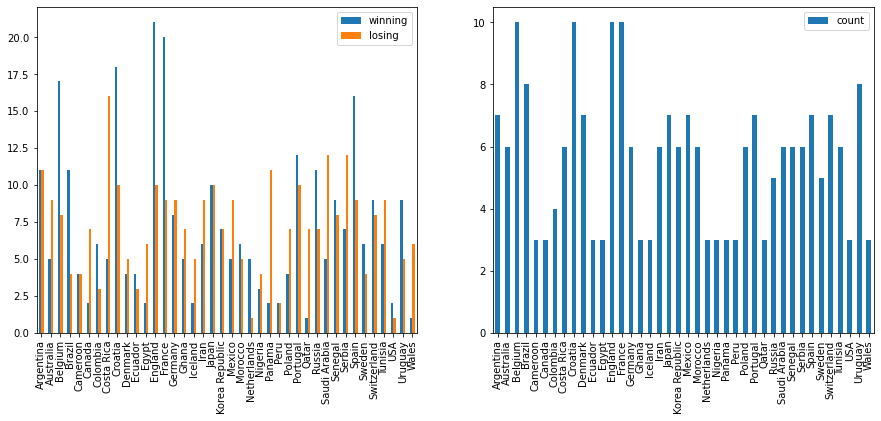

In [153]:
fig, axes  = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(15,6))
fifa['yg1'] = fifa['yg1'].astype(int)
fifa['yg2'] = fifa['yg2'].astype(int)
allgames = fifa.groupby(['team_one']).sum().rename(columns = {'yg1':'winning','yg2':'losing'}) + fifa.groupby(['team_two']).sum().rename(columns = {'yg1':'losing','yg2':'winning'})
allgames.index.name = None
allgames[['winning','losing']].plot.bar(ax = axes[0])

allgames_count = fifa.groupby(['team_one']).count().rename(columns = {'g1':'count'}) + fifa.groupby(['team_two']).count().rename(columns = {'g1':'count'})
allgames_count.index.name = None
allgames_count[['count']].plot.bar(ax = axes[1])
plt.show()

In [149]:
fifa[(fifa['team_one'] == "England") | (fifa['team_two'] == "England")]

,Date,team_one,team_two,yg1,yg2,g1,g2
13,18/06/2018 21:00,Tunisia,England,1,2,13,22
29,24/06/2018 15:00,England,Panama,6,1,22,31
47,28/06/2018 21:00,England,Belgium,0,1,22,12
55,03/07/2018 21:00,Colombia,England,1,1,14,22
58,07/07/2018 17:00,Sweden,England,0,2,11,22
61,11/07/2018 21:00,England,Croatia,1,2,22,7
62,14/07/2018 17:00,Belgium,England,2,0,12,22
1,21/11/2022 13:00,England,Iran,6,2,22,17
19,25/11/2022 19:00,England,USA,0,0,22,33
34,29/11/2022 19:00,Wales,England,0,3,34,22


In [7]:
team_id_map = {team: idx for idx, team in enumerate(fifa["team_one"].unique())}
fifa['g1'] = fifa["team_one"].apply(lambda x: team_id_map[x])
fifa['g2'] = fifa["team_two"].apply(lambda x: team_id_map[x])
n_teams = max(team_id_map.values()) + 1
team_id_map

{'Russia': 0,
 'Egypt': 1,
 'Morocco': 2,
 'Portugal': 3,
 'France': 4,
 'Argentina': 5,
 'Peru': 6,
 'Croatia': 7,
 'Costa Rica': 8,
 'Germany': 9,
 'Brazil': 10,
 'Sweden': 11,
 'Belgium': 12,
 'Tunisia': 13,
 'Colombia': 14,
 'Poland': 15,
 'Uruguay': 16,
 'Iran': 17,
 'Denmark': 18,
 'Nigeria': 19,
 'Serbia': 20,
 'Korea Republic': 21,
 'England': 22,
 'Japan': 23,
 'Saudi Arabia': 24,
 'Spain': 25,
 'Australia': 26,
 'Iceland': 27,
 'Mexico': 28,
 'Switzerland': 29,
 'Senegal': 30,
 'Panama': 31,
 'Qatar': 32,
 'USA': 33,
 'Wales': 34,
 'Netherlands': 35,
 'Cameroon': 36,
 'Ecuador': 37,
 'Canada': 38,
 'Ghana': 39}

In [70]:
train, test = train_test_split(fifa, test_size=0.3, random_state=42)

In [9]:
goals_team_one_obs = train["yg1"].values.astype(int)
goals_team_two_obs = train["yg2"].values.astype(int)
team_one = train["g1"].values
team_two = train["g2"].values

In [10]:
with pm.Model() as model:

    # attack
    tau_att = pm.Gamma("tau_att", 0.1, 0.1)
    atts_star = pm.Normal("atts_star", mu=0, tau=tau_att, shape=n_teams)

    # defence
    tau_def = pm.Gamma("tau_def", 0.1, 0.1)
    def_star = pm.Normal("def_star", mu=0, tau=tau_def, shape=n_teams)

    # sum zero
    atts = pm.Deterministic("atts", atts_star - tt.mean(atts_star))
    defs = pm.Deterministic("defs", def_star - tt.mean(def_star))

    # theta
    team_one_theta = tt.exp(atts[team_one] + defs[team_two])
    team_two_theta = tt.exp(atts[team_two] + defs[team_one])

    # goal expectation
    team_one_points = pm.Poisson("team_one_goals", mu=team_one_theta, observed=goals_team_one_obs)
    team_two_points = pm.Poisson("team_two_goals", mu=team_two_theta, observed=goals_team_two_obs)

In [11]:
with model:
    trace = pm.sample(2000, tune=1000, cores=6, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Lisa\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\Lisa\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [def_star, tau_def, atts_star, tau_att]


Sampling 6 chains for 1_000 tune and 2_000 draw iterations (6_000 + 12_000 draws total) took 686 seconds.
WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
The number of effective samples is smaller than 25% for some parameters.


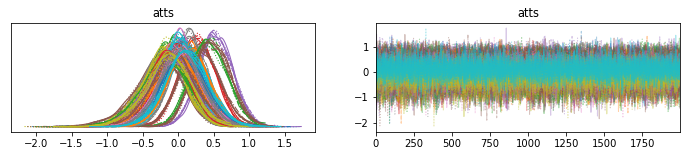

In [154]:
with model:
    pm.plot_trace(trace, var_names=["atts"])

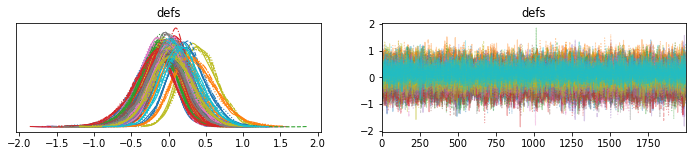

In [155]:
with model:
    pm.plot_trace(trace, var_names=["defs"])

In [44]:
teams_unique = [0] * n_teams
for ele in team_id_map.keys():
    teams_unique[team_id_map[ele]] = ele

atts = pd.DataFrame(az.stats.hdi(trace["atts"]), columns=["lower_hdi", "upper_hdi"])
atts['median'] = np.quantile(trace["atts"], 0.5, axis=0)
atts['lower'] = atts['median'] - atts['lower_hdi']
atts['upper'] = atts['upper_hdi'] - atts['median']
atts.index = teams_unique

atts = atts[['median','lower_hdi','upper_hdi','lower','upper']]
atts = atts.sort_values('median')

C:\Users\Lisa\AppData\Local\Temp\ipykernel_24096\3000531312.py:5: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  atts = pd.DataFrame(az.stats.hdi(trace["atts"]), columns=["lower_hdi", "upper_hdi"])


In [45]:
defs = pd.DataFrame(az.stats.hdi(trace["defs"]), columns=["lower_hdi", "upper_hdi"])
defs['median'] = np.quantile(trace["defs"], 0.5, axis=0)
defs['lower'] = defs['median'] - defs['lower_hdi']
defs['upper'] = defs['upper_hdi'] - defs['median']
defs.index = teams_unique

defs = defs[['median','lower_hdi','upper_hdi','lower','upper']]
defs = defs.sort_values('median', ascending = False)

C:\Users\Lisa\AppData\Local\Temp\ipykernel_24096\3694678829.py:1: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  defs = pd.DataFrame(az.stats.hdi(trace["defs"]), columns=["lower_hdi", "upper_hdi"])


In [161]:
az.rcparams.rcParams["stats.hdi_prob"]

0.94

In [164]:
pd.concat([atts[['median','lower_hdi','upper_hdi']],
           defs[['median','lower_hdi','upper_hdi']]],
          keys = ['atts','defs'],
          axis = 1).sort_index()

atts                          defs                    
                  median lower_hdi upper_hdi    median lower_hdi upper_hdi
Argentina       0.298898 -0.197345  0.821112  0.010565 -0.470518  0.484420
Australia      -0.094718 -0.667402  0.434477  0.055255 -0.441171  0.526396
Belgium        -0.187858 -0.765177  0.353860 -0.143328 -0.675077  0.309852
Brazil          0.027509 -0.459310  0.521248 -0.193855 -0.725139  0.280384
Cameroon        0.021750 -0.546094  0.608914  0.015364 -0.495511  0.528754
Canada         -0.137099 -0.802193  0.454666  0.048630 -0.484362  0.600319
Colombia       -0.052065 -0.681197  0.606547  0.040207 -0.514046  0.614341
Costa Rica     -0.142160 -0.687890  0.361972  0.397916 -0.021484  0.901830
Croatia         0.148151 -0.302364  0.607373 -0.040468 -0.472051  0.388842
Denmark        -0.125209 -0.672516  0.413301 -0.075163 -0.564438  0.383867
Ecuador         0.027804 -0.559665  0.571618 -0.040109 -0.559370  0.464268
Egypt          -0.133297 -0.756900  0.425747  0.139592 -0.343233  0.665803
England         0.427595 -0.017542  0.942841 -0.147292 -0.664809  0.324261
France          0.522506  0.087194  0.996787 -0.046139 -0.497797  0.379018
Germany         0.147654 -0.372171  0.715342  0.099364 -0.380197  0.619599
Ghana           0.120089 -0.434504  0.697275  0.178875 -0.296752  0.697903
Iceland        -0.148133 -0.761702  0.428860  0.054692 -0.437641  0.564768
Iran           -0.205090 -0.776574  0.388345 -0.150396 -0.688786  0.319252
Japan          -0.023945 -0.596516  0.521516 -0.070872 -0.601770  0.400546
Korea Republic  0.146567 -0.391937  0.672683  0.046985 -0.455209  0.517747
Mexico         -0.208899 -0.801159  0.367111  0.001234 -0.499737  0.478069
Morocco        -0.046762 -0.578318  0.441372 -0.131896 -0.648563  0.291828
Netherlands    -0.059590 -0.705953  0.595776 -0.049569 -0.673669  0.473213
Nigeria        -0.061616 -0.627548  0.514681 -0.001277 -0.503180  0.506689
Panama         -0.030290 -0.662003  0.555244  0.328360 -0.177898  0.920618
Peru           -0.147161 -0.767850  0.432818 -0.144309 -0.699916  0.345906
Poland         -0.262137 -0.942699  0.342232 -0.055923 -0.606696  0.475583
Portugal        0.272155 -0.194172  0.740842  0.071451 -0.337104  0.505938
Qatar          -0.167977 -0.856996  0.474527  0.028669 -0.555553  0.584897
Russia          0.097042 -0.428127  0.630278  0.090743 -0.369728  0.587935
Saudi Arabia    0.023418 -0.611159  0.682503 -0.035089 -0.591098  0.539285
Senegal         0.050928 -0.545290  0.742425 -0.047095 -0.620425  0.478336
Serbia          0.057777 -0.444549  0.580653  0.240713 -0.216912  0.738648
Spain           0.465690 -0.028037  0.928957  0.060159 -0.383554  0.527262
Sweden         -0.156341 -0.780479  0.420615 -0.027170 -0.519278  0.469996
Switzerland     0.017686 -0.472254  0.506347  0.016852 -0.460754  0.461876
Tunisia        -0.081122 -0.637864  0.457114 -0.107316 -0.606753  0.359580
USA            -0.134350 -0.754857  0.418979 -0.196640 -0.765180  0.317410
Uruguay         0.037338 -0.454659  0.515604 -0.171002 -0.647716  0.287298
Wales          -0.120882 -0.783762  0.476868  0.068910 -0.485411  0.570597

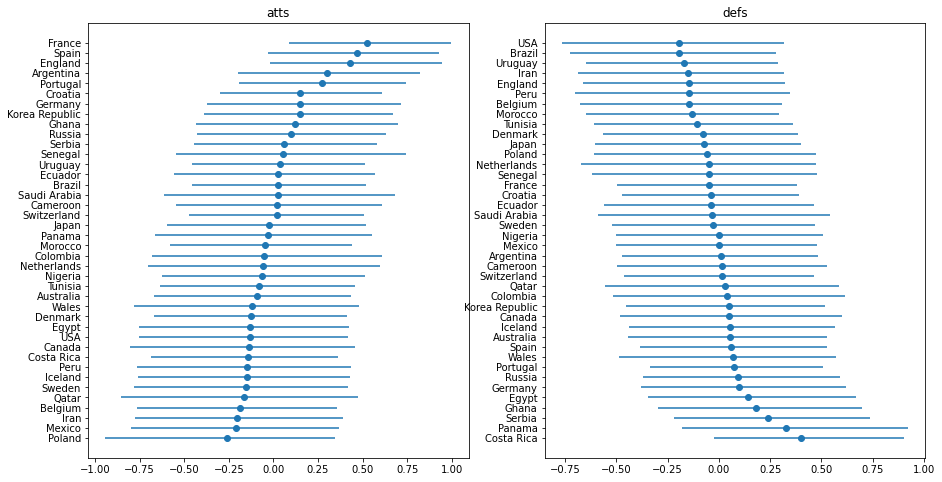

In [166]:
fig, axes  = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(15,8))
axes[0].errorbar(
    atts["median"],
    atts.index,
    xerr=(atts[["lower", "upper"]].values).T,
    fmt="o",
)
axes[0].set_title("atts")

axes[1].errorbar(
    defs["median"],
    defs.index,
    xerr=(defs[["lower", "upper"]].values).T,
    fmt="o",
)
axes[1].set_title("defs")
plt.show()

In [52]:
def goal_expectation(trace, team_one_id, team_two_id):   
    atts_one = np.mean([x[team_one_id] for x in trace["atts"]])
    atts_two = np.mean([x[team_two_id] for x in trace["atts"]])
    defs_one = np.mean([x[team_one_id] for x in trace["defs"]])
    defs_two = np.mean([x[team_two_id] for x in trace["defs"]])

    one_theta = np.exp(atts_one + defs_two)
    two_theta = np.exp(atts_two + defs_one)

    return one_theta, two_theta

In [76]:
series = test.apply(lambda x: goal_expectation(trace, x.g1, x.g2), axis = 1)
test['team_one_pred'] = series.apply(lambda x:x[0])
test['team_two_pred'] = series.apply(lambda x:x[1])
test['team_one_win'] = test['yg1'].astype(int) > test['yg2'].astype(int)
test['team_one_win_pred'] = test['team_one_pred'] > test['team_two_pred']

In [177]:
test[["Date", "team_one", "team_two","yg1","yg2","team_one_pred","team_two_pred","team_one_win","team_one_win_pred"]][test["team_one_win"]!=test["team_one_win_pred"]]

,Date,team_one,team_two,yg1,yg2,team_one_pred,team_two_pred,team_one_win,team_one_win_pred
47,28/06/2018 21:00,England,Belgium,0,1,1.320502,0.697282,False,True
26,23/06/2018 15:00,Belgium,Tunisia,5,2,0.724558,0.785710,True,False
11,18/06/2018 15:00,Sweden,Korea Republic,1,0,0.889083,1.121224,True,False
10,17/06/2018 21:00,Brazil,Switzerland,1,1,1.042910,0.822818,False,True
44,28/06/2018 17:00,Japan,Poland,0,1,0.910959,0.696145,False,True
4,22/11/2022 10:00,Argentina,Saudi Arabia,1,2,1.302272,1.034396,False,True
0,14/06/2018 18:00,Russia,Saudi Arabia,5,0,1.063148,1.131812,True,False
53,02/07/2018 21:00,Belgium,Japan,3,2,0.754099,0.832233,True,False
39,30/11/2022 19:00,Saudi Arabia,Mexico,1,2,1.026273,0.769726,False,True
27,27/11/2022 19:00,Spain,Germany,1,1,1.774194,1.237728,False,True


In [172]:
print(classification_report(test['team_one_win'], test['team_one_win_pred'])) #no draw

              precision    recall  f1-score   support

       False       0.65      0.50      0.56        22
        True       0.35      0.50      0.41        12

    accuracy                           0.50        34
   macro avg       0.50      0.50      0.49        34
weighted avg       0.54      0.50      0.51        34



In [173]:
confusion_matrix(test['team_one_win'], test['team_one_win_pred'])

array([[11, 11],
       [ 6,  6]], dtype=int64)

In [87]:
mean_absolute_error(list(test['yg1'].astype(int)) + list(test['yg2'].astype(int)), list(test['team_one_pred']) + list(test['team_two_pred']))

1.0536581700545953

In [90]:
series = train.apply(lambda x: goal_expectation(trace, x.g1, x.g2), axis = 1)
train['team_one_pred'] = series.apply(lambda x:x[0])
train['team_two_pred'] = series.apply(lambda x:x[1])
train['team_one_win'] = train['yg1'].astype(int) > train['yg2'].astype(int)
train['team_one_win_pred'] = train['team_one_pred'] > train['team_two_pred']

In [91]:
train

,Date,team_one,team_two,yg1,yg2,g1,g2,team_one_pred,team_two_pred,team_one_win,team_one_win_pred
33,25/06/2018 17:00,Saudi Arabia,Egypt,2,1,24,1,1.189522,0.831905,True,True
56,06/07/2018 17:00,Uruguay,France,0,2,16,4,0.984585,1.408466,False,False
0,20/11/2022 16:00,Qatar,Ecuador,0,2,32,37,0.797849,1.063057,False,False
28,23/06/2018 21:00,Germany,Sweden,2,1,9,11,1.129133,0.941261,True,True
15,24/11/2022 19:00,Brazil,Serbia,2,0,10,20,1.321212,0.858496,True,True
...,...,...,...,...,...,...,...,...,...,...,...
42,01/12/2022 19:00,Japan,Spain,2,1,23,25,1.033918,1.474022,True,False
14,19/06/2018 15:00,Colombia,Japan,1,2,14,23,0.871795,1.017096,False,False
28,28/11/2022 10:00,Cameroon,Serbia,3,3,36,20,1.307895,1.078922,False,True
51,01/07/2018 21:00,Croatia,Denmark,1,1,7,18,1.067370,0.835571,False,True


In [170]:
print(classification_report(train['team_one_win'], train['team_one_win_pred'])) #no draw

              precision    recall  f1-score   support

       False       0.80      0.61      0.69        46
        True       0.58      0.78      0.67        32

    accuracy                           0.68        78
   macro avg       0.69      0.69      0.68        78
weighted avg       0.71      0.68      0.68        78



In [93]:
mean_absolute_error(list(train['yg1'].astype(int)) + list(train['yg2'].astype(int)), list(train['team_one_pred']) + list(train['team_two_pred']))

0.7786184005826152

### Prediction

In [178]:
goals_team_one_obs = fifa["yg1"].values.astype(int)
goals_team_two_obs = fifa["yg2"].values.astype(int)
team_one = fifa["g1"].values
team_two = fifa["g2"].values

In [181]:
with pm.Model() as model:

    # attack
    tau_att = pm.Gamma("tau_att", 0.1, 0.1)
    atts_star = pm.Normal("atts_star", mu=0, tau=tau_att, shape=n_teams)

    # defence
    tau_def = pm.Gamma("tau_def", 0.1, 0.1)
    def_star = pm.Normal("def_star", mu=0, tau=tau_def, shape=n_teams)

    # sum zero
    atts = pm.Deterministic("atts", atts_star - tt.mean(atts_star))
    defs = pm.Deterministic("defs", def_star - tt.mean(def_star))

    # theta
    team_one_theta = tt.exp(atts[team_one] + defs[team_two])
    team_two_theta = tt.exp(atts[team_two] + defs[team_one])

    # goal expectation
    team_one_points = pm.Poisson("team_one_goals", mu=team_one_theta, observed=goals_team_one_obs)
    team_two_points = pm.Poisson("team_two_goals", mu=team_two_theta, observed=goals_team_two_obs)

In [182]:
with model:
    trace = pm.sample(2000, tune=1000, cores=6, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Lisa\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\Lisa\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [def_star, tau_def, atts_star, tau_att]


Sampling 6 chains for 1_000 tune and 2_000 draw iterations (6_000 + 12_000 draws total) took 720 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [183]:
atts = pd.DataFrame(az.stats.hdi(trace["atts"]), columns=["lower_hdi", "upper_hdi"])
atts['median'] = np.quantile(trace["atts"], 0.5, axis=0)
atts['lower'] = atts['median'] - atts['lower_hdi']
atts['upper'] = atts['upper_hdi'] - atts['median']
atts.index = teams_unique

atts = atts[['median','lower_hdi','upper_hdi','lower','upper']]
atts = atts.sort_values('median')

C:\Users\Lisa\AppData\Local\Temp\ipykernel_24096\1111447179.py:1: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  atts = pd.DataFrame(az.stats.hdi(trace["atts"]), columns=["lower_hdi", "upper_hdi"])


In [185]:
defs = pd.DataFrame(az.stats.hdi(trace["defs"]), columns=["lower_hdi", "upper_hdi"])
defs['median'] = np.quantile(trace["defs"], 0.5, axis=0)
defs['lower'] = defs['median'] - defs['lower_hdi']
defs['upper'] = defs['upper_hdi'] - defs['median']
defs.index = teams_unique

defs = defs[['median','lower_hdi','upper_hdi','lower','upper']]
defs = defs.sort_values('median', ascending = False)

C:\Users\Lisa\AppData\Local\Temp\ipykernel_24096\3694678829.py:1: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  defs = pd.DataFrame(az.stats.hdi(trace["defs"]), columns=["lower_hdi", "upper_hdi"])


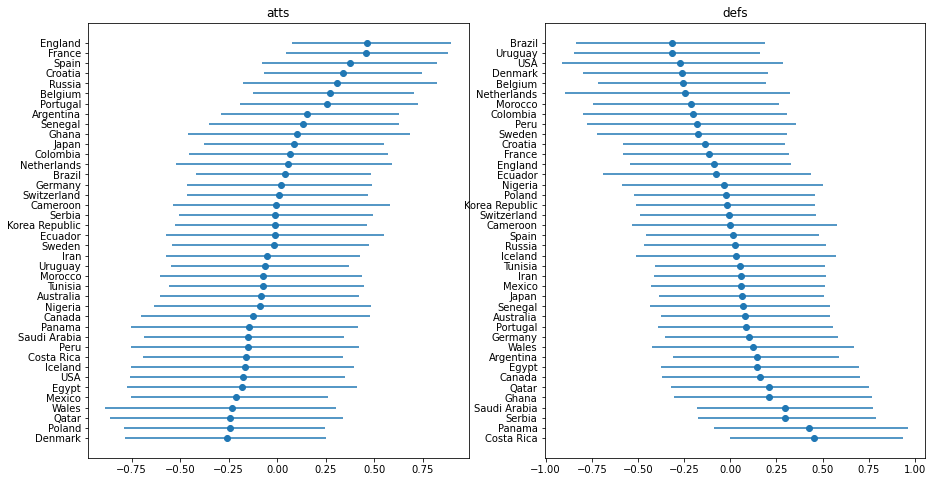

In [186]:
fig, axes  = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(15,8))
axes[0].errorbar(
    atts["median"],
    atts.index,
    xerr=(atts[["lower", "upper"]].values).T,
    fmt="o",
)
axes[0].set_title("atts")

axes[1].errorbar(
    defs["median"],
    defs.index,
    xerr=(defs[["lower", "upper"]].values).T,
    fmt="o",
)
axes[1].set_title("defs")
plt.show()

### On the coming round of 16

In [187]:
round_of_16 = remaining_games[remaining_games['Round Number']=='Round of 16']
round_of_16['team_one'] = round_of_16['Home Team'].apply(lambda x: team_id_map[x])
round_of_16['team_two'] = round_of_16['Away Team'].apply(lambda x: team_id_map[x])
round_of_16 = round_of_16.rename(columns = {'Home Team':'team_one_name','Away Team':'team_two_name'})

In [188]:
series = round_of_16.apply(lambda x: goal_expectation(trace, x.team_one, x.team_two), axis = 1)
round_of_16['team_one_pred'] = series.apply(lambda x:x[0])
round_of_16['team_two_pred'] = series.apply(lambda x:x[1])

In [189]:
round_of_16[["Date","Location","team_one_name","team_two_name","team_one_pred","team_two_pred"]]

,Date,Location,team_one_name,team_two_name,team_one_pred,team_two_pred
48,03/12/2022 15:00,Khalifa International Stadium,Netherlands,USA,0.788957,0.635282
49,03/12/2022 19:00,Ahmad Bin Ali Stadium,Argentina,Australia,1.268039,1.051048
50,04/12/2022 15:00,Al Thumama Stadium,France,Poland,1.541730,0.680527
51,04/12/2022 19:00,Al Bayt Stadium,England,Senegal,1.695580,1.034771
52,05/12/2022 15:00,Al Janoub Stadium,Japan,Croatia,0.945130,1.497161
53,05/12/2022 19:00,Stadium 974,Brazil,Korea Republic,1.009920,0.707056
54,06/12/2022 15:00,Education City Stadium,Morocco,Spain,0.938232,1.162538
55,06/12/2022 19:00,Lusail Stadium,Portugal,Switzerland,1.284238,1.096698


### Updates: Quarter Final

In [9]:
fifa_2022 = pd.read_csv("fifa-world-cup-2022-UTC-new.csv")
fifa_2018 = pd.read_csv("fifa-world-cup-2018-RussianStandardTime.csv")

remaining_games = fifa_2022[fifa_2022['Result'].isna()]

fifa_2022 = fifa_2022.dropna()
fifa = pd.concat([fifa_2018,fifa_2022],axis = 0)

fifa["home_team_goal"] = fifa["Result"].apply(lambda x: x.split(" - ")[0])
fifa["away_team_goal"] = fifa["Result"].apply(lambda x: x.split(" - ")[1])
fifa = fifa.rename(
    columns = {
        "Home Team":"team_one",
        "Away Team":"team_two",
        "home_team_goal":"yg1",
        "away_team_goal":"yg2",
    }
)

fifa = fifa[["Date", "team_one", "team_two", "yg1", "yg2"]]

team_id_map = {team: idx for idx, team in enumerate(fifa["team_one"].unique())}
fifa['g1'] = fifa["team_one"].apply(lambda x: team_id_map[x])
fifa['g2'] = fifa["team_two"].apply(lambda x: team_id_map[x])
n_teams = max(team_id_map.values()) + 1

goals_team_one_obs = fifa["yg1"].values.astype(int)
goals_team_two_obs = fifa["yg2"].values.astype(int)
team_one = fifa["g1"].values
team_two = fifa["g2"].values

In [10]:
fifa

,Date,team_one,team_two,yg1,yg2,g1,g2
0,14/06/2018 18:00,Russia,Saudi Arabia,5,0,0,24
1,15/06/2018 15:00,Egypt,Uruguay,0,1,1,16
2,15/06/2018 18:00,Morocco,Iran,0,1,2,17
3,15/06/2018 21:00,Portugal,Spain,3,3,3,25
4,16/06/2018 13:00,France,Australia,2,1,4,26
...,...,...,...,...,...,...,...
51,04/12/2022 19:00,England,Senegal,3,0,22,30
52,05/12/2022 15:00,Japan,Croatia,1,1,23,7
53,05/12/2022 19:00,Brazil,Korea Republic,4,1,10,21
54,06/12/2022 15:00,Morocco,Spain,0,0,2,25


In [11]:
with pm.Model() as model:

    # attack
    tau_att = pm.Gamma("tau_att", 0.1, 0.1)
    atts_star = pm.Normal("atts_star", mu=0, tau=tau_att, shape=n_teams)

    # defence
    tau_def = pm.Gamma("tau_def", 0.1, 0.1)
    def_star = pm.Normal("def_star", mu=0, tau=tau_def, shape=n_teams)

    # sum zero
    atts = pm.Deterministic("atts", atts_star - tt.mean(atts_star))
    defs = pm.Deterministic("defs", def_star - tt.mean(def_star))

    # theta
    team_one_theta = tt.exp(atts[team_one] + defs[team_two])
    team_two_theta = tt.exp(atts[team_two] + defs[team_one])

    # goal expectation
    team_one_points = pm.Poisson("team_one_goals", mu=team_one_theta, observed=goals_team_one_obs)
    team_two_points = pm.Poisson("team_two_goals", mu=team_two_theta, observed=goals_team_two_obs)
    
with model:
    trace = pm.sample(2000, tune=1000, cores=6, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Lisa\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\Lisa\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [def_star, tau_def, atts_star, tau_att]


Sampling 6 chains for 1_000 tune and 2_000 draw iterations (6_000 + 12_000 draws total) took 649 seconds.
The number of effective samples is smaller than 25% for some parameters.


C:\Users\Lisa\AppData\Local\Temp\ipykernel_22120\38237733.py:5: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  atts = pd.DataFrame(az.stats.hdi(trace["atts"]), columns=["lower_hdi", "upper_hdi"])
C:\Users\Lisa\AppData\Local\Temp\ipykernel_22120\38237733.py:15: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  defs = pd.DataFrame(az.stats.hdi(trace["defs"]), columns=["lower_hdi", "upper_hdi"])


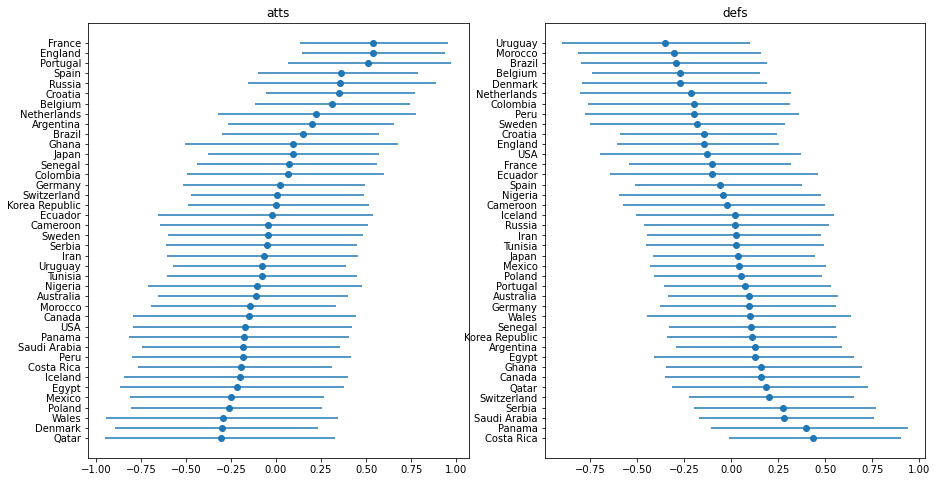

In [12]:
teams_unique = [0] * n_teams
for ele in team_id_map.keys():
    teams_unique[team_id_map[ele]] = ele

atts = pd.DataFrame(az.stats.hdi(trace["atts"]), columns=["lower_hdi", "upper_hdi"])
atts['median'] = np.quantile(trace["atts"], 0.5, axis=0)
atts['lower'] = atts['median'] - atts['lower_hdi']
atts['upper'] = atts['upper_hdi'] - atts['median']
atts.index = teams_unique

atts = atts[['median','lower_hdi','upper_hdi','lower','upper']]
atts = atts.sort_values('median')


defs = pd.DataFrame(az.stats.hdi(trace["defs"]), columns=["lower_hdi", "upper_hdi"])
defs['median'] = np.quantile(trace["defs"], 0.5, axis=0)
defs['lower'] = defs['median'] - defs['lower_hdi']
defs['upper'] = defs['upper_hdi'] - defs['median']
defs.index = teams_unique

defs = defs[['median','lower_hdi','upper_hdi','lower','upper']]
defs = defs.sort_values('median', ascending = False)


fig, axes  = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(15,8))
axes[0].errorbar(
    atts["median"],
    atts.index,
    xerr=(atts[["lower", "upper"]].values).T,
    fmt="o",
)
axes[0].set_title("atts")

axes[1].errorbar(
    defs["median"],
    defs.index,
    xerr=(defs[["lower", "upper"]].values).T,
    fmt="o",
)
axes[1].set_title("defs")
plt.show()

In [23]:
def goal_expectation(trace, team_one_id, team_two_id):   
    atts_one = np.mean([x[team_one_id] for x in trace["atts"]])
    atts_two = np.mean([x[team_two_id] for x in trace["atts"]])
    defs_one = np.mean([x[team_one_id] for x in trace["defs"]])
    defs_two = np.mean([x[team_two_id] for x in trace["defs"]])

    one_theta = np.exp(atts_one + defs_two)
    two_theta = np.exp(atts_two + defs_one)

    return one_theta, two_theta

quarter_final = remaining_games[remaining_games['Round Number']=='Quarter Finals']
quarter_final['team_one'] = quarter_final['Home Team'].apply(lambda x: team_id_map[x])
quarter_final['team_two'] = quarter_final['Away Team'].apply(lambda x: team_id_map[x])
quarter_final = quarter_final.rename(columns = {'Home Team':'team_one_name','Away Team':'team_two_name'})

series = quarter_final.apply(lambda x: goal_expectation(trace, x.team_one, x.team_two), axis = 1)
quarter_final['team_one_pred'] = series.apply(lambda x:x[0])
quarter_final['team_two_pred'] = series.apply(lambda x:x[1])

atts_score = atts['median'].to_dict()
defs_score = defs['median'].to_dict()

quarter_final['team_one_attack_score'] = quarter_final['team_one_name'].apply(lambda x: atts_score[x])
quarter_final['team_one_defense_score'] = quarter_final['team_one_name'].apply(lambda x: -defs_score[x])

quarter_final['team_two_attack_score'] = quarter_final['team_two_name'].apply(lambda x: atts_score[x])
quarter_final['team_two_defense_score'] = quarter_final['team_two_name'].apply(lambda x: -defs_score[x])

quarter_final[["Date","Location","team_one_name","team_one_pred","team_one_attack_score","team_one_defense_score","team_two_name","team_two_pred","team_two_attack_score","team_two_defense_score"]].transpose()

C:\Users\Lisa\AppData\Local\Temp\ipykernel_22120\3135141014.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quarter_final['team_one'] = quarter_final['Home Team'].apply(lambda x: team_id_map[x])
C:\Users\Lisa\AppData\Local\Temp\ipykernel_22120\3135141014.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quarter_final['team_two'] = quarter_final['Away Team'].apply(lambda x: team_id_map[x])


,56,57,58,59
Date,09/12/2022 15:00,09/12/2022 19:00,10/12/2022 15:00,10/12/2022 19:00
Location,Education City Stadium,Lusail Stadium,Al Thumama Stadium,Al Bayt Stadium
team_one_name,Croatia,Netherlands,Morocco,England
team_one_pred,1.045971,1.431078,0.928808,1.537391
team_one_attack_score,0.350703,0.223529,-0.145746,0.538535
team_one_defense_score,0.145463,0.21061,0.303225,0.144591
team_two_name,Brazil,Argentina,Portugal,France
team_two_pred,0.997692,0.969658,1.212798,1.476332
team_two_attack_score,0.151065,0.197775,0.509449,0.539446
team_two_defense_score,0.292891,-0.127492,-0.076456,0.100678


### Future work: Overshrinkage

- Hierarchical Bayesian model has a well-known drawback: overshrinkage
- One fix is to allow for 3 different generating mechanisms, one for top, one for mid and one for bottom
- Berger(1984) found that shrinkage can be limited by modelling attack and defense with non-central distribution on 4 degrees of freedom instead of normal